*You can skip to the next section. Here, we just set up some helpers for visualizing expression graphs and neural networks.*

In [1]:
from graphviz import Digraph

from neural.core import Addition, Multiplication, Node, Power, Tanh, Value


SYMBOLS = {
  Addition: "+",
  Multiplication: "*",
  Power: "**",
  Tanh: "tanh",
  Value: None,
}


def symbol(node):
  return SYMBOLS[type(node)]


def trace(root):
  nodes, edges = set(), set()
  stack = [root]

  while len(stack) > 0:
    node = stack.pop()
    nodes.add(node)
    for pred in node.pred:
      edges.add((pred, node))
      stack.append(pred)

  return nodes, edges


def render(root, labels = {}, grads = {}):
  graph = Digraph(format="svg", graph_attr={"rankdir": "LR"})
  
  nodes, edges = trace(root)

  nid = lambda node: str(id(node))
  oid = lambda node, op: f"{nid(node)}-{op}"

  for node in nodes:
    label = f"{node.data:.4f}"
    label = f"{{ {labels[node]} | {label} }}" if node in labels else label

    graph.node(name=nid(node), label=label, shape="record")
    op = symbol(node)

    if op is not None:
      graph.node(name=oid(node, op), label=op, shape="circle")
      graph.edge(oid(node, op), nid(node))

  for start, end in edges:
    op = symbol(end)
    label = f"{grads[start]:.4f}" if start in grads else None

    if op is not None:
      graph.edge(nid(start), oid(end, op), label=label)
    else:
      graph.edge(nid(start), nid(end), label=label)
  
  return graph

In [2]:
from itertools import pairwise

def viz(nn):
  graph = Digraph(format="svg", graph_attr={"rankdir": "LR"})

  nid = lambda neuron: str(id(neuron))
    
  for i, layer in enumerate(nn.layers, start=1):
    with graph.subgraph(name=f"cluster-{i}") as g:
      g.attr(label=f"Layer {i}", style="filled", color="lightblue")

      for neuron in layer.neurons:
        g.node(name=nid(neuron), label="", shape="circle", style="filled", color="white")

  for l1, l2 in pairwise(nn.layers):
    for n1 in l1.neurons:
      for n2 in l2.neurons:
        graph.edge(nid(n1), nid(n2))

  first = nn.layers[0]
    
  for i in range(max(len(n.w) for n in first.neurons)):
    name = f"input-{i}"
    graph.node(name=name, shape="point")
    for neuron in first:
      graph.edge(name, nid(neuron))
    
  return graph

## Basic Neuron and Backpropagation

I recommend watching Andrej Karpathy’s [*spelled-out intro to neural networks and backpropagation*](https://www.youtube.com/watch?v=VMj-3S1tku0).

For my own implementation of the presented concepts, take a look at the source code in `neural/core.py`.

Here, we construct a simple [artificial neuron](https://en.wikipedia.org/wiki/Artificial_neuron) with two inputs to visualize it and apply backpropagation.

*What's an artificial neuron?* It's a model for a [biological neuron](https://en.wikipedia.org/wiki/Neuron).

Each input component $x_i$ (think "stimulus received through a [dendrite](https://en.wikipedia.org/wiki/Dendrite) in a biological neuron") is weighted according to the neurons [synaptic weights](https://en.wikipedia.org/wiki/Synaptic_weight) $w_i$ ("how strong is the connection?"). A bias $b$ is added, loosely corresponding to the [threshold potential](https://en.wikipedia.org/wiki/Threshold_potential). Lastly, an [activation function](https://en.wikipedia.org/wiki/Activation_function) is applied, which determines the output of our neuron along its [axon](https://en.wikipedia.org/wiki/Axon).

$n(x) = \varphi(\sum_{i=0}^{k}{w_ix_i} + b)$

Here is how we build a simple neuron with just two inputs, using [tanh](https://en.wikipedia.org/wiki/Hyperbolic_functions#Hyperbolic_tangent) as an activation function.

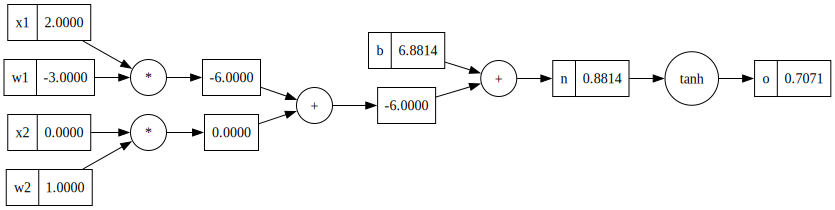

In [3]:
from neural.core import tanh

x1 = Value(2.0)
x2 = Value(0.0)

w1 = Value(-3.0)
w2 = Value(1.0)

b = Value(6.8813735870195432)

n = (x1 * w1) + (x2 * w2) + b
o = tanh(n)

labels = {x1: "x1", x2: "x2", w1: "w1", w2: "w2", b: "b", n: "n", o: "o"}

render(o, labels=labels)

Now that we’ve built it, we can backpropagate through it, see the impact that nudging each of the components would have on the output (gradients).

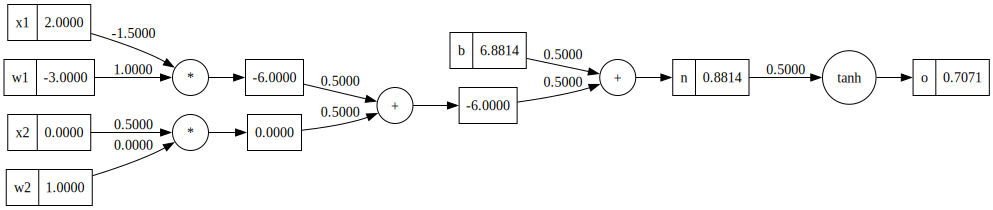

In [4]:
from neural.core import backprop

grads = backprop(o)

render(o, labels=labels, grads=grads)

## Multi-Layer Perceptron

In short, a Multilayer Perceptron:

- consists of layers of neurons
- outputs of neurons in each layer are connected as inputs to all neurons in the next
- each of these connections is weighted

See [Wikipedia: Multilayer Perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron).

Source code: `neural/nets.py`

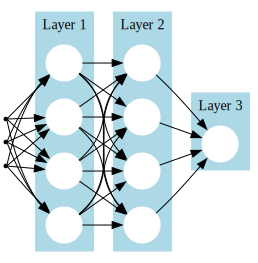

In [5]:
from neural.nets import Neuron, Layer, MLP

nn = MLP(3, [4, 4, 1], tanh)

viz(nn)

## Training

Define inputs `xs` and expected outputs `ys`.

In [6]:
xs = [[2.0, 3.0, -1.0], [3.0, -1.0, 0.5], [1.0, 1.0, -1.0], [0.5, 1.0, 1.0]]
ys = [1.0, -1.0, 1.0, -1.0]

Run the net on all inputs and collect the results as `pred`. Compute the loss.

In [7]:
pred = [nn(x)[0] for x in xs]

loss = sum((target - actual)**2 for (target, actual) in zip(ys, pred))

loss.data / len(pred) # mean squared error

1.469382701919598

Visualize target values, the network predictions, and distance.

In [8]:
from pandas import DataFrame

DataFrame(data=((target, actual.data, abs(target - actual.data)) for (target, actual) in zip(ys, pred)), columns=["target", "actual", "distance"])

,target,actual,distance
0,1.0,-0.372437,1.372437
1,-1.0,0.155822,1.155822
2,1.0,-0.416427,1.416427
3,-1.0,-0.192687,0.807313


Propagate back through the network from the loss. Show current parameter values and the gradients (with regard to the loss).

In [9]:
from pandas import DataFrame

grads = backprop(loss)

df = DataFrame(data=((p.data, grads[p]) for p in nn.params()), columns=["value", "grad"])

df

,value,grad
0,0.436334,-1.384967
1,0.789297,0.366743
2,-0.343070,-0.324070
3,-0.161194,-0.533233
4,-0.496741,0.040499
5,0.677735,0.060985
6,-0.631467,0.052855
7,0.380705,0.061305
8,-0.767046,0.506591
9,0.043395,0.756990


[Gradient descent](https://en.wikipedia.org/wiki/Gradient_descent): Adjust parameters in the opposite direction of the gradient (in small increments).

In [10]:
for p in nn.params():
    p.data -= 0.1 * grads[p]

Jump back up to run the network with the adjusted parameters, see the updated predictions, and loss. Repeat.